In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("bank.csv")
data.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
10456,45,blue-collar,married,primary,no,900,yes,no,unknown,9,jun,213,1,-1,0,unknown,no
8637,40,housemaid,married,tertiary,no,795,yes,no,unknown,29,may,725,3,-1,0,unknown,no
5148,49,management,married,tertiary,no,4751,no,no,cellular,12,aug,884,4,-1,0,unknown,yes
871,36,management,married,tertiary,no,0,no,no,telephone,27,aug,645,9,-1,0,unknown,yes
4508,23,services,single,secondary,no,279,yes,no,cellular,18,may,843,1,370,1,failure,yes


In [3]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [4]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

In [5]:
df = data.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome','deposit']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

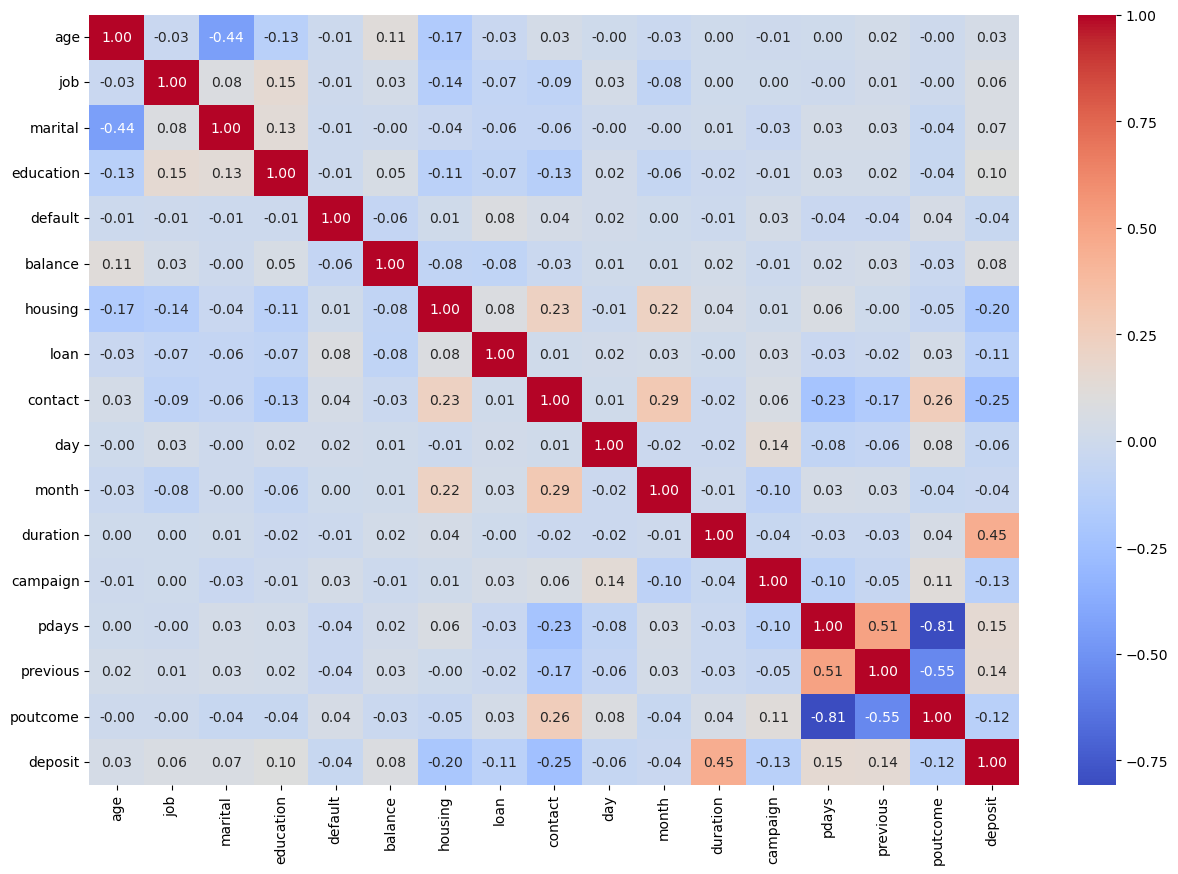

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

# Findings
The following columns offer critical insights into customer behaviour in the dataset: `duration`,`contact` and `housing`.
### duration
The high positive correlation suggests that the longer the call the higher the likelihood of a customer to subscribe. This is likely due to an uninterested customer is unlikely to keep the conversation going.
The "trap" here is that the model will over-rely on a feature that: one, cannot be used to predict how long a call will last to convince the customer and second, a feature that will not be present at the time you need to make a prediction in real life(this is after the fact feature). This feature is introducing data leakage from outside.
### contact
The negative correlation is related to how the data was encoded where cellphone was likely given a lower coding such as 0. Cellphone contributed most to conversions.
### housing
The negative correlation is also related to how the data was encoded, where "yes" was given a coding of 1 and "no". Customers without housing loan were more likely to take up the product.

# Strategic takeaways
Drop `duration`. Even if it's the strongest to correlate, the model must learn to make predictions using other features.
The model will likely find the "ideal" customer is one that will be contacted via cellphone.

In [8]:
y = df['deposit']
X = df.drop(columns =['deposit','duration'])

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_res, y_train_res)

LogisticRegression()

In [13]:
y_pred = model.predict(X_test_scaled)
y_probs = model.predict_proba(X_test_scaled)[:,1]

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n",classification_report(y_test,y_pred))

Accuracy Score: 0.64576802507837

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65      1175
           1       0.62      0.67      0.64      1058

    accuracy                           0.65      2233
   macro avg       0.65      0.65      0.65      2233
weighted avg       0.65      0.65      0.65      2233



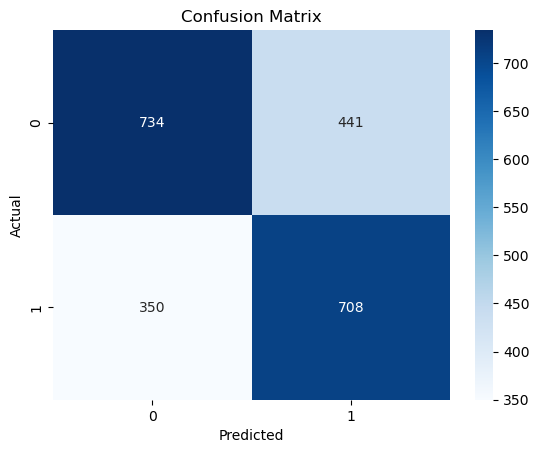

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
brf_model.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(max_depth=10, random_state=42)

In [17]:
y_pred_brf = brf_model.predict(X_test_scaled)
y_probs_rf = brf_model.predict_proba(X_test_scaled)[:,1]

In [18]:
from sklearn.metrics import roc_auc_score

brf_accuracy = accuracy_score(y_test, y_pred_brf)
brf_roc_auc = roc_auc_score(y_test, y_pred_brf)

print(f"Balanced RF Accuracy Score:{brf_accuracy}")
print(f"Balanced RF ROC_AUC_SCORE:{brf_roc_auc}")
print("\nClassification Report:\n",classification_report(y_test, y_pred_brf))

Balanced RF Accuracy Score:0.7223466188983431
Balanced RF ROC_AUC_SCORE:0.7193234927402165

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      1175
           1       0.73      0.66      0.69      1058

    accuracy                           0.72      2233
   macro avg       0.72      0.72      0.72      2233
weighted avg       0.72      0.72      0.72      2233



Text(0.5, 1.0, 'Confusion Matrix')

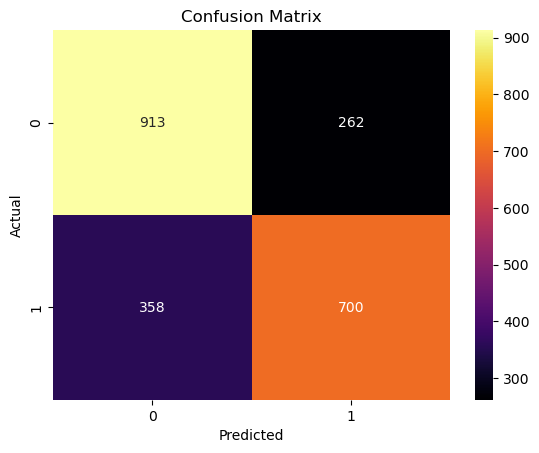

In [19]:
brf_cm = confusion_matrix(y_test, y_pred_brf)
sns.heatmap(brf_cm, annot = True, fmt = 'd', cmap = 'inferno')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

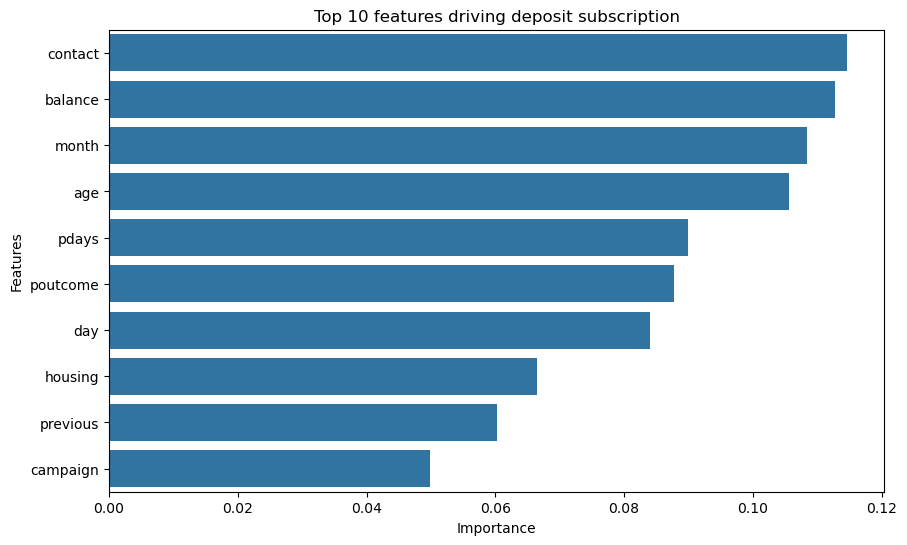

In [20]:
importances = brf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Features" : feature_names, "Importance" : importances })
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10,6))
sns.barplot(x = 'Importance', y = 'Features', data = feature_importance_df.head(10))
plt.title("Top 10 features driving deposit subscription")
plt.show()

In [21]:
dfxg = data.copy()

In [22]:
dfxg['job_education'] = dfxg['job'].astype(str)+ '_' +dfxg['education'].astype(str)
print(dfxg[['job', 'education', 'job_education']].head())

          job  education         job_education
0      admin.  secondary      admin._secondary
1      admin.  secondary      admin._secondary
2  technician  secondary  technician_secondary
3    services  secondary    services_secondary
4      admin.   tertiary       admin._tertiary


In [23]:
X = pd.get_dummies(dfxg.drop(columns = ['duration', 'deposit']), drop_first = True, dtype = int)
y = dfxg['deposit'].map({'no':0,'yes':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
import xgboost as xgb
num_pos = sum(y_train == 1)
num_neg = sum(y_train == 0)
balance_weight = num_pos/num_neg if num_pos > 0 else 1

xgb_model = xgb.XGBClassifier(
    gamma = 1,
    reg_lambda = 2,
    max_depth = 5,
    objective = 'binary:logistic',
    use_label_encoder = False,
    eval_metric = 'logloss',
    scale_pos_weight = balance_weight,
    n_estimators = 100,
    random_state = 42,
    learning_rate = 0.05
)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_probs_xgb = xgb_model.predict_proba(X_test_scaled)[:,1]

In [25]:
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_roc = roc_auc_score(y_test, y_pred_xgb)
print(f"Accuracy Score:{xgb_accuracy}")
print(f"ROC AUC Score: {xgb_roc}")
print("\nClassification Report\n:", classification_report(y_test, y_pred_xgb))

Accuracy Score:0.7317510076130765
ROC AUC Score: 0.723506817359128

Classification Report
:               precision    recall  f1-score   support

           0       0.69      0.88      0.78      1175
           1       0.81      0.57      0.67      1058

    accuracy                           0.73      2233
   macro avg       0.75      0.72      0.72      2233
weighted avg       0.75      0.73      0.72      2233



In [27]:
y_pred_strict = (y_probs > 0.6).astype(int)
xgb_accuracy_strict = accuracy_score(y_test, y_pred_strict)
xgb_roc_strict = roc_auc_score(y_test, y_pred_strict)
print(f"Accuracy Score:{xgb_accuracy_strict}")
print(f"ROC AUC Score: {xgb_roc_strict}")
print("\nClassification Report\n:", classification_report(y_test, y_pred_strict))

Accuracy Score:0.6614420062695925
ROC AUC Score: 0.6534513131963159

Classification Report
:               precision    recall  f1-score   support

           0       0.64      0.81      0.71      1175
           1       0.70      0.50      0.58      1058

    accuracy                           0.66      2233
   macro avg       0.67      0.65      0.65      2233
weighted avg       0.67      0.66      0.65      2233



In [28]:
results = pd.DataFrame(index = X_test.index)
results["Actual_Deposit"] = y_test
results["Predicted_Deposit"] = y_pred_xgb
results["Deposit_Probability"] = y_probs_xgb

results = results.join(dfxg[['age', 'job','marital']])
results.to_csv('deposit_predictions_2025.csv')
print("Evaluation complete. File saved as 'deposit_predictions_2025.csv'")
print(results.head())

Evaluation complete. File saved as 'deposit_predictions_2025.csv'
      Actual_Deposit  Predicted_Deposit  Deposit_Probability  age  \
8220               0                  0             0.321163   32   
2521               1                  1             0.507841   36   
7949               0                  1             0.766645   52   
7879               0                  0             0.147257   35   
616                1                  0             0.221096   41   

              job  marital  
8220   management  married  
2521   technician   single  
7949       admin.  married  
7879   management   single  
616   blue-collar  married  


In [29]:
import pickle

with open("xbg_deposit_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
print("Model successfully saved as pickle")

Model successfully saved as pickle
